### <span style='color:lightgreen;'>อัลกอริทึม Inter-Mean</span>
อัลกอริทึม Inter-Mean (หรือที่เรียกว่า Intermeans/Iterative Mean Thresholding) เป็นวิธีในงานประมวลผลภาพเพื่อแบ่งภาพออกเป็นส่วนพื้นหน้า (foreground) และพื้นหลัง (background) โดยการหาค่า threshold ที่เหมาะสม ค่า threshold นี้ถูกหาโดยการคำนวณค่าเฉลี่ยของพิกเซลทั้งสองฝั่งของค่า threshold ที่เดาไว้ แล้วนำค่าเฉลี่ยทั้งสองมาหาเฉลี่ยอีกครั้งเพื่อได้ค่า threshold ใหม่ ทำซ้ำแบบวนจนกว่าค่าจะลู่เข้าสู่ค่าคงตัว (threshold ไม่เปลี่ยนแปลงอย่างมีนัยสำคัญ)

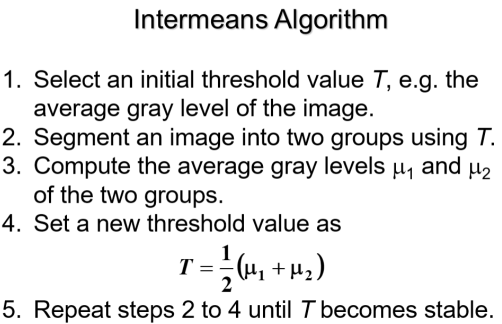

คำอธิบายละเอียดเพิ่มเติม:

#### <span style='color:lightblue;'>กระบวนการทั้งหมดใน Python</span>  
1. **<span style='color:lightgreen;'>นำเข้าไลบรารีและกำหนดฟังก์ชัน</span>**
    - นำเข้าไลบรารีที่จำเป็นและกำหนดฟังก์ชันที่เขียนเอง.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
def ShowImage(img):
    plt.axis("off")
    plt.imshow(img, cmap='gray')
    plt.show()

In [3]:
def histogram(img):
    row, col = img.shape
    hist = [0.0] * 256
    for i in range(row):
        for j in range(col):
            hist[img[i, j]]+=1
    return np.array(hist)

In [4]:
def ResizeImage(img, scale):
    row, col = img.shape
    dim = (int(col*scale), int(row*scale))
    return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

2. **<span style='color:lightgreen;'>อ่านภาพ</span>**
    - โหลดและปรับขนาดภาพด้วย OpenCV.

In [5]:
img = cv2.imread('./images/bank4.jpg', cv2.IMREAD_GRAYSCALE)
print(img.shape)

(514, 1200)


In [6]:
img = ResizeImage(img, 0.5)
print(img.shape)

(257, 600)


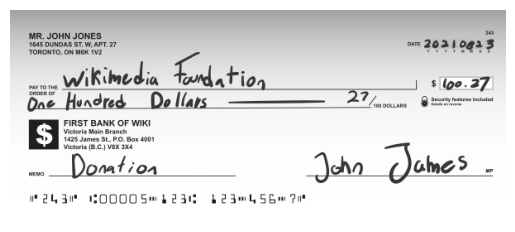

In [7]:
ShowImage(img)

3. **<span style='color:lightgreen;'>คำนวณฮิสโตแกรม</span>**
    - คำนวณฮิสโตแกรมของภาพ.

In [8]:
hist = histogram(img)
print(hist.shape)

(256,)


In [9]:
dir(hist)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_function__',
 '__array_interface__',
 '__array_namespace__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__buffer__',
 '__class__',
 '__class_getitem__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__divmod__',
 '__dlpack__',
 '__dlpack_device__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',


4. **<span style='color:lightgreen;'>วาดกราฟฮิสโตแกรม</span>**
    - ใช้ Matplotlib เพื่อแสดงฮิสโตแกรม.

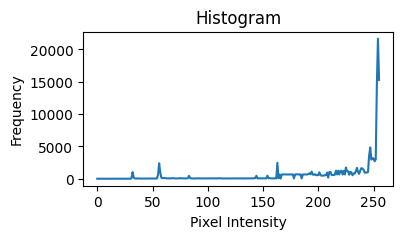

In [10]:
plt.figure(figsize=(4,2))
plt.plot(hist)
plt.title('Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()
# plt.savefig('histogram.png')

5. **<span style='color:lightgreen;'>คำนวณค่า Threshold ด้วยอัลกอริทึม Intermean แบบทีละขั้นตอน</span>**
    - **<span style='color:lightgreen;'>กำหนดค่า Threshold เริ่มต้น</span>**

In [11]:
thresh = 30 # int(np.mean(img))
print(thresh)

30


 - **<span style='color:lightgreen;'>คำนวณความน่าจะเป็นของฮิสโตแกรม</span>**

 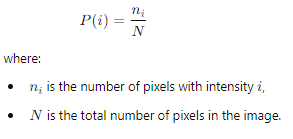

In [15]:
Tot = np.sum(hist)
print(f"Total = {Tot}"," img shape =", img.shape[0]*img.shape[1])

prob = hist/Tot # คือค่าความน่าจะเป็นของแต่ละความเข้มแสง
print(prob.shape)

Total = 154200.0  img shape = 154200
(256,)


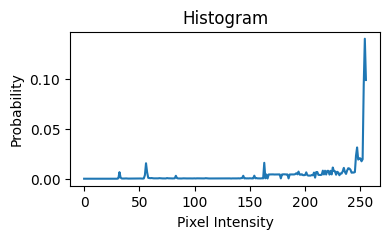

1.0


In [16]:
plt.figure(figsize=(4,2))
plt.plot(prob)
plt.title('Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Probability')
plt.show()

print(np.sum(prob))

In [17]:
print(prob.sum())

1.0


 - **<span style='color:green;'>แยกฮิสโตแกรมเป็น 2 กลุ่ม และหาผลรวมสะสมของความน่าจะเป็นของแต่ละกลุ่ม</span>**

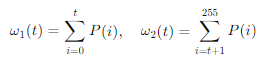

ทำไมต้อง + 0.00000001?
- เพื่อป้องกันการหารด้วยศูนย์ ในขั้นตอนต่อไป
- ถ้า w0 หรือ w1 เป็น 0 จะเกิด error เมื่อหาค่าเฉลี่ย

โค้ดนี้คือ การคำนวณผลรวมสะสมของความน่าจะเป็นของแต่ละกลุ่ม ในอัลกอริทึม Inter-Mean:

In [21]:
w0 = np.sum(prob[:thresh]) + 0.00000001 # เลือกค่าความน่าจะเป็นตั้งแต่ดัชนี 0 ถึง thresh-1
w1 = np.sum(prob[thresh:]) + 0.00000001

print(w0, w1)

1.2980168612191959e-05 0.9999870398313878


 - **<span style='color:lightgreen;'>คำนวณค่าเฉลี่ยของแต่ละกลุ่มจากฮิสโตแกรม</span>**

 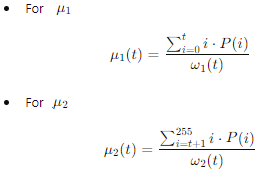

โค้ดนี้คือ การคำนวณค่าเฉลี่ย (mean) ของความเข้มแสงในแต่ละกลุ่ม:

In [22]:
u0 = np.sum(np.array([i for i in range(thresh)])*prob[:thresh])/w0 #ค่าเฉลี่ยของพิกเซลที่มีค่า < thresh (พื้นหลัง)
u1 = np.sum(np.array([i for i in range(thresh,256)])*prob[thresh:])/w1 #คำนวณค่าเฉลี่ยของพิกเซลที่มีค่า ≥ thresh (พื้นหน้า)

แบบเขียนเต็มของโค้ดบน

In [ ]:
x = 0.
for i in range(thresh):
    x = x + 1 * prob[i]
    

In [20]:
print(u0, u1, thresh)

10.991525533813432 219.49480318511922 30


sx = 0
for i in range(thresh):
    sx = sx + (i*prob[i])
u0 = sx/w0

sx = 0
for i in range(thresh, 256):
    sx = sx + (i*prob[i])
u1 = sx/w1

 - **<span style='color:lightgreen;'>คำนวณค่าเฉลี่ยระหว่างค่าเฉลี่ยทั้งสองกลุ่ม</span>**

In [ ]:
if (u0 == 0.0): #u0 คือค่าเฉลี่ยของพื้นหลัง
    thr = u1 #ถ้าค่าเฉลี่ยของพื้นหลัง = 0 ให้ค่า thresh = ค่าเฉลี่ยของพื้นหน้า
elif (u1 == 0.0):
    thr = u0 #
else:
    thr =int((u0 +u1) / 2) # คือค่าเฉลี่ยของค่าเฉลี่ยทั้งสองส่วน
print(thresh, thr) 

30 115


#### <span style='color:lightgreen;'>อัลกอริทึม InterMean</span>**

In [24]:
def intermean(hist, t):
    prob = hist/np.sum(hist)
    
    w0 = np.sum(prob[:t]) + 0.00000001
    w1 = np.sum(prob[t:]) + 0.00000001
    
    u0 = np.sum(np.array([i for i in range(t)])*prob[:t])/w0
    u1 = np.sum(np.array([i for i in range(t,256)])*prob[t:])/w1
    if (u0 == 0.0):
        thr = u1
    elif (u1 == 0.0):
        thr = u0
    else:
        thr = (u0 +u1) / 2

    return thr.astype('int16')

 - **<span style='color:lightgreen;'>กระบวนการหลัก</span>**

In [ ]:
T0 = 18
#T0 = int(np.mean(img))
flag = True
Tlist = []
Tlist.append(T0)
while (flag):
    T1 = intermean(hist, T0)
    Tlist.append(T1)
    if (math.fabs(T1 -T0) < 1):
        flag = False
    else:
        T0 = T1
print(Tlist)

[18, np.int16(110), np.int16(145), np.int16(152), np.int16(154), np.int16(154)]


In [26]:
T = Tlist[-1]
print(T)

154


 - **<span style='color:lightgreen;'>ขั้นตอนหา Threshold วิธีที่ 1</span>**

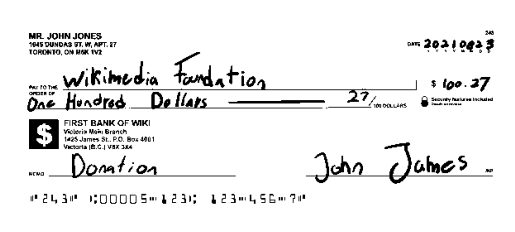

In [27]:
out = np.zeros_like(img)
thresh = T
out[img >= thresh] = 255
out = out.astype(np.uint8)
ShowImage(out)

 - **<span style='color:lightgreen;'>ขั้นตอนหา Threshold วิธีที่ 2</span>**

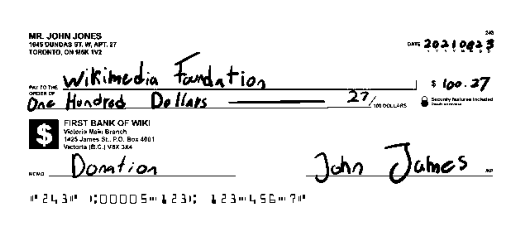

In [28]:
ret, bimg_2 = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY)
ShowImage(bimg_2)